# Importation des données

In [2]:
import pickle

with open('.\\data\\prepared_data\\useful\\X_useful_train.pkl', 'rb') as f:
    X_useful_train = pickle.load(f)
    
with open('.\\data\\prepared_data\\useful\\Y_useful_train.pkl', 'rb') as f:
    Y_useful_train = pickle.load(f)

type(X_useful_train)
type(Y_useful_train)
X_useful_train.info()
Y_useful_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 3465 to 1125
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PCA0    3528 non-null   float64
 1   PCA1    3528 non-null   float64
 2   PCA2    3528 non-null   float64
 3   PCA3    3528 non-null   float64
 4   PCA4    3528 non-null   float64
 5   PCA5    3528 non-null   float64
 6   PCA6    3528 non-null   float64
 7   PCA7    3528 non-null   float64
 8   PCA8    3528 non-null   float64
 9   PCA9    3528 non-null   float64
 10  PCA10   3528 non-null   float64
 11  PCA11   3528 non-null   float64
 12  PCA12   3528 non-null   float64
 13  PCA13   3528 non-null   float64
 14  PCA14   3528 non-null   float64
dtypes: float64(15)
memory usage: 441.0 KB
<class 'pandas.core.series.Series'>
Int64Index: 3528 entries, 3465 to 1125
Series name: Attrition
Non-Null Count  Dtype 
--------------  ----- 
3528 non-null   object
dtypes: object(1)
memory usage: 55.1+ KB


# Entrainement des modèles

In [3]:
from sklearn.preprocessing import LabelEncoder

# Instantiate label encoder
label_encoder = LabelEncoder()

# Fit and transform y_train
y_train_useful_encoded = label_encoder.fit_transform(Y_useful_train)

0.0

In [ ]:
### Arbre de décision
from sklearn.tree import DecisionTreeClassifier
import numpy as np

tree_class = DecisionTreeClassifier(random_state=42)
tree_class.fit(X_useful_train, y_train_useful_encoded)
from sklearn.metrics import mean_squared_error

useful_predictions = tree_class.predict(X_useful_train)
tree_mse = mean_squared_error(y_train_useful_encoded, useful_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

Scores: [0.10644926 0.19914833 0.17652613 0.11901389 0.19914833 0.18437553
 0.15967389 0.17652613 0.13055824 0.15075567]
Mean: 0.16021753850025963
Standard deviation: 0.03115289075838951


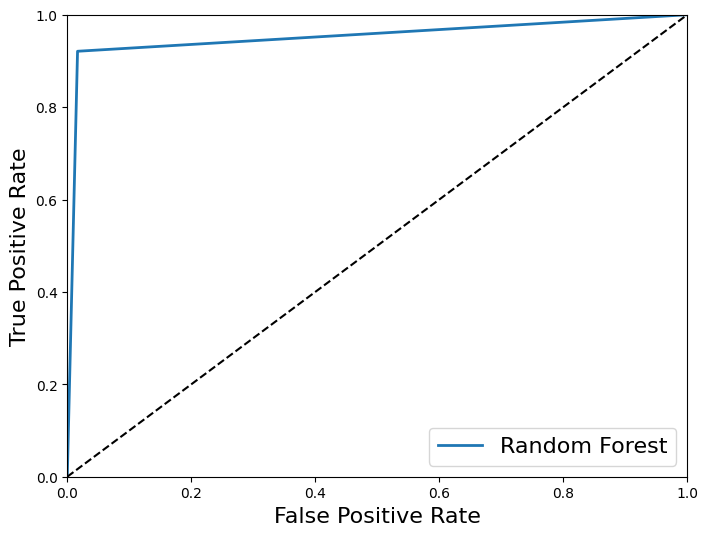

0.9521771177385605

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

scores = cross_val_score(tree_class, X_useful_train, y_train_useful_encoded,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_predict = cross_val_predict(tree_class, X_useful_train, y_train_useful_encoded, cv=10, method='predict_proba')

display_scores(tree_rmse_scores)
tree_scores = tree_predict[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_useful_encoded,tree_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

roc_auc_score(y_train_useful_encoded, tree_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialiser le modèle RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf.fit(X_useful_train, Y_useful_train)

# Évaluer les performances du modèle sur l'ensemble de test
y_pred = rf.predict(X_useful_test)
accuracy = accuracy_score(y_useful_test, y_pred)
print(f"Accuracy: {accuracy}")

## Pipeline

La pipeline fait référence à un ensemble d'étapes ou de processus qui sont exécutés séquentiellement pour traiter les données d'entrée, extraire des caractéristiques, entraîner le modèle et prédire les résultats.


In [75]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy

# Settings
pd.set_option('display.max_columns', None)

# Global variables
GENERAL_DATA_PATH = "./data/general_data.csv"
EMPLOYEE_SURVEY_DATA_PATH = "./data/employee_survey_data.csv"
MANAGER_SURVEY_DATA_PATH = "./data/manager_survey_data.csv"
IN_TIME_DATA_PATH = "./data/in_out_time/in_time.csv"
OUT_TIME_DATA_PATH = "./data/in_out_time/out_time.csv"


## Acquisition des données

Collecter des données brutes à partir de diverses sources, telles que des capteurs, des fichiers, des bases de données, etc.


In [76]:
def agregate_dataframes(list_df: list, on_column: str, how: str) -> pd.DataFrame:
    '''
    Merge dataframes.

    Parameters
    ----------
    list_df : list
        List of dataframes to merge.
    on_column : str
        Column to merge on.
    how : str
        Type of merge.

    Returns
    -------
    df_master : pandas.DataFrame
        Dataframe with all dataframes merged.

    Example
    -------
    >>> df1 = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, 6]})
    >>> df2 = pd.DataFrame({"A": [1, 2, 3], "C": [7, 8, 9]})
    >>> df3 = pd.DataFrame({"A": [1, 2, 3], "D": [10, 11, 12]})
    >>> df_master = agregate_dataframes([df1, df2, df3], "A", "outer")
    >>> df_master
        A    B    C     D
    0  1.0  4.0  7.0  10.0
    1  2.0  5.0  8.0  11.0
    2  3.0  6.0  9.0  12.0
    '''
    df_master = list_df[0]
    for df in list_df[1:]:
        df_master = df_master.merge(df,
                                    on=on_column,
                                    how=how)
    return df_master


def avg_time(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Calculate the average time of in_time and out_time.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with in_time or out_time.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with EmployeeID and AvgTime.

    Example
    -------
    >>> df = pd.DataFrame({"EmployeeID": [1, 2, 3], "InTime": ["2020-01-01 08:00:00", "2020-01-01 08:00:00", "2020-01-01 08:00:00"]})
    >>> df = avg_time(df)
    >>> df
        EmployeeID   AvgTime
    0           1  08:00:00
    1           2  08:00:00
    2           3  08:00:00
    '''
    # Set first column as index
    df = df.copy().set_index(df.columns[0])
    # Remove first column
    df = df.copy().transpose()

    # Convert datetime to normalized time format
    df = df.apply(pd.to_datetime)
    df = df.apply(lambda x: x - x.dt.normalize())
    df = df.mean(skipna=True)
    # Add column EmployeeID
    df = df.to_frame().reset_index()
    df.columns = ["EmployeeID", "AvgTime"]
    return df


In [77]:
# Load data
df_general = pd.read_csv(GENERAL_DATA_PATH, sep=',')
df_employee_survey = pd.read_csv(EMPLOYEE_SURVEY_DATA_PATH, sep=',')
df_manager_survey = pd.read_csv(MANAGER_SURVEY_DATA_PATH, sep=',')
df_in_time = pd.read_csv(IN_TIME_DATA_PATH, sep=',')
df_out_time = pd.read_csv(OUT_TIME_DATA_PATH, sep=',')

# Merge dataframes
df_total = agregate_dataframes(
    [df_general, df_employee_survey, df_manager_survey],
    "EmployeeID",
    "outer"
)

# --- HANDLE IN AND OUT TIME ---
# Get average in time
avg_in_time_per_employee = avg_time(df_in_time)
# Get average out time
avg_out_time_per_employee = avg_time(df_out_time)
# Merge in and out time
avg_work_time_per_employee = avg_out_time_per_employee.copy()
avg_work_time_per_employee["AvgTime"] = avg_out_time_per_employee["AvgTime"] - \
    avg_in_time_per_employee["AvgTime"]
avg_work_time_per_employee["AvgTime"] = avg_work_time_per_employee["AvgTime"].apply(
    lambda x: x.total_seconds() / 3600)

# Merge with total dataframe
df_total = df_total.merge(
    avg_work_time_per_employee,
    on="EmployeeID",
    how="outer"
)


In [78]:
# Display a random sample of 5 rows
df_total.sample(5)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgTime
2957,37,No,Non-Travel,Research & Development,1,3,Medical,1,2958,Male,2,Sales Executive,Divorced,41270,2.0,Y,13,8,1,15.0,2,5,0,2,1.0,4.0,3.0,3,3,11.001879
3794,38,Yes,Travel_Rarely,Research & Development,2,3,Medical,1,3795,Female,3,Sales Executive,Married,49080,4.0,Y,19,8,1,7.0,3,5,1,4,3.0,2.0,3.0,2,3,7.579078
3188,37,No,Travel_Rarely,Research & Development,4,3,Medical,1,3189,Male,1,Manager,Married,98840,1.0,Y,14,8,0,10.0,3,10,7,8,3.0,3.0,3.0,2,3,6.228324
2473,38,No,Travel_Rarely,Research & Development,8,2,Technical Degree,1,2474,Female,1,Manufacturing Director,Married,25140,3.0,Y,11,8,0,15.0,2,1,1,0,2.0,4.0,3.0,2,3,9.004005
2800,36,No,Travel_Rarely,Research & Development,1,3,Medical,1,2801,Female,2,Manufacturing Director,Divorced,175670,5.0,Y,13,8,0,7.0,6,1,0,0,1.0,4.0,3.0,3,3,7.506159


## Prétraitement des données


Nettoyer, normaliser et préparer les données pour l'analyse ultérieure.


### Nettoyage des données


Une étude préablable a permis de déterminer quels champs n'apportaient pas d'informations utiles à la prédiction. De même pour les champs non éthiques.


In [79]:
fields_not_useful = [
    "Over18",  # We have age
    "EducationField",  # We have Education
    "EmployeeCount",  # All at 1
    "StockOptionLevel",  # Not relevant
]
fields_not_ethical = [
    "Gender",
    "MaritalStatus",
]

# Datframe with only useful fields
df_useful = deepcopy(df_total)
df_useful.drop(
    fields_not_useful,
    axis=1,
    inplace=True
)
print("Shape useful:", df_useful.shape)

# Datframe with useful and ethical fields
df_ethical = deepcopy(df_total)
df_ethical.drop(
    fields_not_useful + fields_not_ethical,
    axis=1,
    inplace=True
)
print("Shape ethical:", df_ethical.shape)

# Delete to free memory
del df_total
del fields_not_useful
del fields_not_ethical


Shape useful: (4410, 26)
Shape ethical: (4410, 24)


### Normalisation des données


In [80]:
# List of columns to merge to add columns
columns_to_merge = [
    ("TotalWorkingYears", "Age"),
    ("YearsAtCompany", "Age"),
    ("NumCompaniesWorked", "Age"),
    ("YearsSinceLastPromotion", "Age"),
    ("YearsWithCurrManager", "Age"),
    ("YearsAtCompany", "TotalWorkingYears"),
    ("YearsSinceLastPromotion", "TotalWorkingYears"),
    ("YearsWithCurrManager", "TotalWorkingYears"),
]


In [81]:
from sklearn.model_selection import train_test_split

# Split train and test sets
X_useful_train_set, X_useful_test_set, y_useful_train_set, y_useful_test_set = train_test_split(
    df_useful, df_useful["Attrition"], stratify=df_useful["Attrition"], test_size=0.2, random_state=42)
X_ethical_train_set, X_ethical_test_set, y_ethical_train_set, y_ethical_test_set = train_test_split(
    df_ethical, df_ethical["Attrition"], stratify=df_ethical["Attrition"], test_size=0.2, random_state=42)

# Remove Attrition and EmployeeID from train and test sets
X_useful_train_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)
X_useful_test_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)
X_ethical_train_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)
X_ethical_test_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)


In [82]:
X_useful_train_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 3465 to 1125
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      3528 non-null   int64  
 1   BusinessTravel           3528 non-null   object 
 2   Department               3528 non-null   object 
 3   DistanceFromHome         3528 non-null   int64  
 4   Education                3528 non-null   int64  
 5   Gender                   3528 non-null   object 
 6   JobLevel                 3528 non-null   int64  
 7   JobRole                  3528 non-null   object 
 8   MaritalStatus            3528 non-null   object 
 9   MonthlyIncome            3528 non-null   int64  
 10  NumCompaniesWorked       3512 non-null   float64
 11  PercentSalaryHike        3528 non-null   int64  
 12  StandardHours            3528 non-null   int64  
 13  TotalWorkingYears        3521 non-null   float64
 14  TrainingTimesLastYear

In [83]:
X_ethical_test_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 3331 to 4229
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      882 non-null    int64  
 1   BusinessTravel           882 non-null    object 
 2   Department               882 non-null    object 
 3   DistanceFromHome         882 non-null    int64  
 4   Education                882 non-null    int64  
 5   JobLevel                 882 non-null    int64  
 6   JobRole                  882 non-null    object 
 7   MonthlyIncome            882 non-null    int64  
 8   NumCompaniesWorked       879 non-null    float64
 9   PercentSalaryHike        882 non-null    int64  
 10  StandardHours            882 non-null    int64  
 11  TotalWorkingYears        880 non-null    float64
 12  TrainingTimesLastYear    882 non-null    int64  
 13  YearsAtCompany           882 non-null    int64  
 14  YearsSinceLastPromotio

In [84]:
X_useful_test_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 3331 to 4229
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      882 non-null    int64  
 1   BusinessTravel           882 non-null    object 
 2   Department               882 non-null    object 
 3   DistanceFromHome         882 non-null    int64  
 4   Education                882 non-null    int64  
 5   Gender                   882 non-null    object 
 6   JobLevel                 882 non-null    int64  
 7   JobRole                  882 non-null    object 
 8   MaritalStatus            882 non-null    object 
 9   MonthlyIncome            882 non-null    int64  
 10  NumCompaniesWorked       879 non-null    float64
 11  PercentSalaryHike        882 non-null    int64  
 12  StandardHours            882 non-null    int64  
 13  TotalWorkingYears        880 non-null    float64
 14  TrainingTimesLastYear 

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Class to add new columns to a dataframe from a list of columns to merge.

    Parameters
    ----------
    column_ids_to_merge : list[tuple[int]]
        List of tuples with the column ids to merge.

    Attributes
    ----------
    column_ids_to_merge : list[tuple[int]]
        List of tuples with the column ids to merge.

    Methods
    -------
    fit(X, y=None)
        Fit the model.

    transform(X, y=None)
        Transform the model.
    """

    def __init__(self, attribs_name_to_merge=[]):
        """
        Init the class.

        Parameters
        ----------
        column_ids_to_merge : list[tuple[int]]
            List of tuples with the column ids to merge.

        Returns
        -------
        None
        """
        self.attribs_name_to_merge = attribs_name_to_merge

    def fit(self, X=None, y=None):
        """
        Fit the model.

        Parameters
        ----------
        X : pandas.DataFrame
            The data to fit the model.

        y : pandas.DataFrame
            The target to fit the model.
            default: None

        Returns
        -------
        self
        """
        return self  # nothing else to do

    def transform(self, X, y=None):
        """
        Transform the model.

        Parameters
        ----------
        X : pandas.DataFrame
            The data to transform the model.

        y : pandas.DataFrame
            The target to transform the model.
            default: None

        Returns
        -------
        numpy.ndarray
            The transformed data.
        """
        if len(self.attribs_name_to_merge) == 0:
            return X
        for ctm in self.attribs_name_to_merge:
            # index1 * index2
            X["%sPer%s" % (ctm[0], ctm[1])] = X[ctm[0]] * X[ctm[1]]
        return X

    def set_output(self, transform):
        """
        Set the output of the model. But here we don't need it because the output is the same as the input.

        Parameters
        ----------
        output : numpy.ndarray
            The output of the model.

        Returns
        -------
        None
        """
        pass


In [86]:
# -- Useful --
# Get numerical attributes
useful_train_set_num = X_useful_train_set.select_dtypes(include=[np.number])

# Create the pipeline for numerical attributes
num_pipeline_useful = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder(columns_to_merge)),
    ('std_scaler', StandardScaler()),
]).set_output(transform="pandas")


In [87]:
# List of categorical attributes
useful_cat_attribs = ["BusinessTravel", "Department",
                      "JobRole", "Gender", "MaritalStatus"]

# Full pipeline
useful_full_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline_useful, useful_train_set_num.keys()),
    ("cat", OneHotEncoder(sparse_output=False), useful_cat_attribs),
], remainder='passthrough').set_output(transform="pandas")


In [88]:
# -- Ethical And Useful --
# Get numerical attributes
ethical_train_set_num = X_ethical_train_set.select_dtypes(include=[np.number])

# Create the pipeline for numerical attributes
num_pipeline_ethical = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder(columns_to_merge)),
    ('std_scaler', StandardScaler()),
]).set_output(transform="pandas")

# List of categorical attributes
ethical_cat_attribs = ["BusinessTravel", "Department", "JobRole"]

# Full pipeline
ethical_full_pipeline = ColumnTransformer([
    ("num", num_pipeline_ethical, ethical_train_set_num.keys()),
    ("cat", OneHotEncoder(sparse_output=False), ethical_cat_attribs),
]).set_output(transform="pandas")


In [89]:
# -- Useful --
useful_train_set_prepared = useful_full_pipeline.fit_transform(
    X_useful_train_set)
# -- Ethical --
ethical_train_set_prepared = ethical_full_pipeline.fit_transform(
    X_ethical_train_set)


In [90]:
useful_train_set_prepared


,num__Age,num__DistanceFromHome,num__Education,num__JobLevel,num__MonthlyIncome,num__NumCompaniesWorked,num__PercentSalaryHike,num__StandardHours,num__TotalWorkingYears,num__TrainingTimesLastYear,num__YearsAtCompany,num__YearsSinceLastPromotion,num__YearsWithCurrManager,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,num__JobInvolvement,num__PerformanceRating,num__AvgTime,num__TotalWorkingYearsPerAge,num__YearsAtCompanyPerAge,num__NumCompaniesWorkedPerAge,num__YearsSinceLastPromotionPerAge,num__YearsWithCurrManagerPerAge,num__YearsAtCompanyPerTotalWorkingYears,num__YearsSinceLastPromotionPerTotalWorkingYears,num__YearsWithCurrManagerPerTotalWorkingYears,cat__BusinessTravel_Non-Travel,cat__BusinessTravel_Travel_Frequently,cat__BusinessTravel_Travel_Rarely,cat__Department_Human Resources,cat__Department_Research & Development,cat__Department_Sales,cat__JobRole_Healthcare Representative,cat__JobRole_Human Resources,cat__JobRole_Laboratory Technician,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__JobRole_Sales Representative,cat__Gender_Female,cat__Gender_Male,cat__MaritalStatus_Divorced,cat__MaritalStatus_Married,cat__MaritalStatus_Single
3465,0.463140,-1.016618,1.05518,-0.969757,-0.259638,-0.679818,-0.341374,0.0,-0.160786,-0.615667,0.508815,-0.677208,1.098882,-0.661977,0.263919,0.337770,1.797989,-0.432065,0.154623,-0.125477,0.483351,-0.606598,-0.616267,1.130307,-0.039219,-0.474799,0.275159,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3485,-0.306868,-1.016618,-1.87606,-0.068228,-0.801808,0.119915,2.102113,0.0,-0.676822,0.162575,-1.149782,-0.677208,-1.146292,0.257856,1.169667,0.337770,0.381440,2.314467,-0.460246,-0.620968,-0.949552,-0.039101,-0.616267,-1.031418,-0.623994,-0.474799,-0.739777,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3052,-1.736884,0.087413,-0.89898,-0.969757,-0.235080,-0.679818,-0.884371,0.0,-1.321867,-0.615667,-0.983923,-0.677208,-1.146292,0.257856,-0.641828,0.337770,0.381440,-0.432065,-1.284879,-1.061138,-0.876159,-0.792662,-0.616267,-1.031418,-0.618146,-0.474799,-0.739777,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2012,-0.966876,-0.280597,0.07810,-0.068228,-0.742531,-0.679818,-0.341374,0.0,-1.321867,0.162575,-0.983923,-0.677208,-1.146292,-1.581810,-0.641828,0.337770,0.381440,-0.432065,-1.059293,-1.044301,-0.851695,-0.727539,-0.616267,-1.031418,-0.618146,-0.474799,-0.739777,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
426,0.353139,-1.016618,1.05518,-0.068228,2.698904,-0.279952,-0.341374,0.0,-0.031777,0.162575,-0.983923,-0.677208,-1.146292,-1.581810,-0.641828,-1.094505,0.381440,-0.432065,-1.219655,-0.053318,-0.809757,-0.243772,-0.616267,-1.031418,-0.559669,-0.474799,-0.739777,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.023135,1.314114,2.03226,-0.068228,0.067866,0.519781,-0.612873,0.0,-0.418804,-1.393910,-0.652203,-0.677208,-0.584999,-1.581810,0.263919,0.337770,0.381440,-0.432065,-0.134231,-0.399681,-0.561620,0.388847,-0.616267,-0.543712,-0.483648,-0.474799,-0.536790,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
613,-1.406880,2.295474,1.05518,0.833301,-0.761584,-0.679818,1.016119,0.0,-1.321867,1.719060,-0.983923,-0.677208,-1.146292,1.177689,-0.641828,-2.526780,0.381440,-0.432065,-0.849662,-1.053922,-0.865675,-0.764752,-0.616267,-1.031418,-0.618146,-0.474799,-0.739777,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
808,-0.416870,-0.280597,-0.89898,-0.068228,-0.581425,2.119247,1.830614,0.0,-0.418804,-0.615667,-0.320484,-0.677208,-0.584999,-1.581810,-0.6

In [91]:
ethical_train_set_prepared


,num__Age,num__DistanceFromHome,num__Education,num__JobLevel,num__MonthlyIncome,num__NumCompaniesWorked,num__PercentSalaryHike,num__StandardHours,num__TotalWorkingYears,num__TrainingTimesLastYear,num__YearsAtCompany,num__YearsSinceLastPromotion,num__YearsWithCurrManager,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,num__JobInvolvement,num__PerformanceRating,num__AvgTime,num__TotalWorkingYearsPerAge,num__YearsAtCompanyPerAge,num__NumCompaniesWorkedPerAge,num__YearsSinceLastPromotionPerAge,num__YearsWithCurrManagerPerAge,num__YearsAtCompanyPerTotalWorkingYears,num__YearsSinceLastPromotionPerTotalWorkingYears,num__YearsWithCurrManagerPerTotalWorkingYears,cat__BusinessTravel_Non-Travel,cat__BusinessTravel_Travel_Frequently,cat__BusinessTravel_Travel_Rarely,cat__Department_Human Resources,cat__Department_Research & Development,cat__Department_Sales,cat__JobRole_Healthcare Representative,cat__JobRole_Human Resources,cat__JobRole_Laboratory Technician,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__JobRole_Sales Representative
3465,0.463140,-1.016618,1.05518,-0.969757,-0.259638,-0.679818,-0.341374,0.0,-0.160786,-0.615667,0.508815,-0.677208,1.098882,-0.661977,0.263919,0.337770,1.797989,-0.432065,0.154623,-0.125477,0.483351,-0.606598,-0.616267,1.130307,-0.039219,-0.474799,0.275159,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3485,-0.306868,-1.016618,-1.87606,-0.068228,-0.801808,0.119915,2.102113,0.0,-0.676822,0.162575,-1.149782,-0.677208,-1.146292,0.257856,1.169667,0.337770,0.381440,2.314467,-0.460246,-0.620968,-0.949552,-0.039101,-0.616267,-1.031418,-0.623994,-0.474799,-0.739777,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3052,-1.736884,0.087413,-0.89898,-0.969757,-0.235080,-0.679818,-0.884371,0.0,-1.321867,-0.615667,-0.983923,-0.677208,-1.146292,0.257856,-0.641828,0.337770,0.381440,-0.432065,-1.284879,-1.061138,-0.876159,-0.792662,-0.616267,-1.031418,-0.618146,-0.474799,-0.739777,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,-0.966876,-0.280597,0.07810,-0.068228,-0.742531,-0.679818,-0.341374,0.0,-1.321867,0.162575,-0.983923,-0.677208,-1.146292,-1.581810,-0.641828,0.337770,0.381440,-0.432065,-1.059293,-1.044301,-0.851695,-0.727539,-0.616267,-1.031418,-0.618146,-0.474799,-0.739777,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
426,0.353139,-1.016618,1.05518,-0.068228,2.698904,-0.279952,-0.341374,0.0,-0.031777,0.162575,-0.983923,-0.677208,-1.146292,-1.581810,-0.641828,-1.094505,0.381440,-0.432065,-1.219655,-0.053318,-0.809757,-0.243772,-0.616267,-1.031418,-0.559669,-0.474799,-0.739777,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.023135,1.314114,2.03226,-0.068228,0.067866,0.519781,-0.612873,0.0,-0.418804,-1.393910,-0.652203,-0.677208,-0.584999,-1.581810,0.263919,0.337770,0.381440,-0.432065,-0.134231,-0.399681,-0.561620,0.388847,-0.616267,-0.543712,-0.483648,-0.474799,-0.536790,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
613,-1.406880,2.295474,1.05518,0.833301,-0.761584,-0.679818,1.016119,0.0,-1.321867,1.719060,-0.983923,-0.677208,-1.146292,1.177689,-0.641828,-2.526780,0.381440,-0.432065,-0.849662,-1.053922,-0.865675,-0.764752,-0.616267,-1.031418,-0.618146,-0.474799,-0.739777,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
808,-0.416870,-0.280597,-0.89898,-0.068228,-0.581425,2.119247,1.830614,0.0,-0.418804,-0.615667,-0.320484,-0.677208,-0.584999,-1.581810,-0.641828,0.337770,0.381440,2.314467,0.146307,-0.476651,-0.372896,1.468021,-0.616267,-0.596437,-0.390084,-0.474799,-0.536790,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2946,-0.966876,0.210083,-0.89898,-0.068228,-0.141931,-0.279952,1.287617,0.0,-0.805831,-0.615667,

In [92]:
# Delete to free memory
del columns_to_merge
del df_useful
del df_ethical
del X_useful_train_set
del X_useful_test_set
del X_ethical_train_set
del X_ethical_test_set
del useful_train_set_num
del ethical_train_set_num
del useful_cat_attribs
del ethical_cat_attribs
del useful_full_pipeline
del ethical_full_pipeline


In [93]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def plot_pca(df):
    # Instanciation de la classe PCA
    pca = PCA()

    # Calcul des composantes principales
    pca.fit(df)

    # Création du graphique de variance expliquée
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Nombre de composantes principales')
    plt.ylabel('Variance expliquée')
    # Ajouter une ligne verticale pour montrer le nombre de composantes principales
    plt.axvline(x=15, color='r', linestyle='--')
    # Changer les borne de l'axe des x
    plt.xlim(0, 30, 5)
    plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_6028\3079959166.py:18: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, 30, 5)


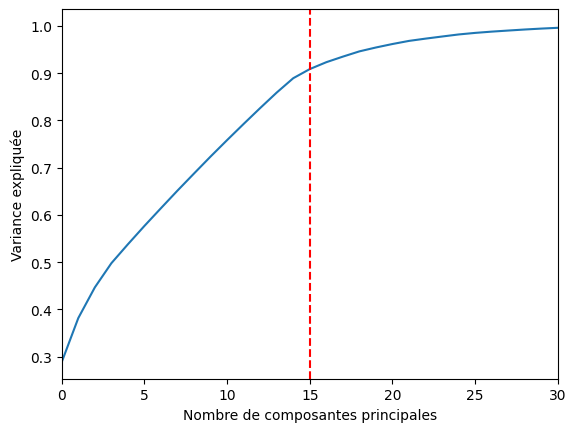

In [94]:
plot_pca(ethical_train_set_prepared)


C:\Users\mathi\AppData\Local\Temp\ipykernel_6028\3079959166.py:18: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, 30, 5)


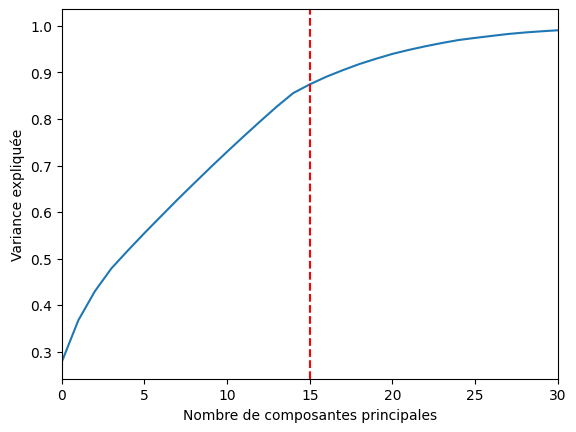

In [95]:
plot_pca(useful_train_set_prepared)


Pour les 2 jeux de données, la réduction de la dimentionnalité semble adaptée. Pour cela, nous allons utiliser l'ACP. Grâce au graphique ci-dessus, nous pouvons voir que les 2 jeux de données sont très proches. Nous allons donc utiliser le même nombre de composantes pour les 2 jeux de données : **15**.


### Sauvegarde du jeu de données


In [96]:
import pickle

# Save data
path_data = "data/prepared_data/"

# make directory if not exists
if not os.path.exists(path_data):
    os.makedirs(path_data)

# -- Useful --
with open(path_data + "useful.pkl", "wb") as f:
    pickle.dump(useful_train_set_prepared, f)

# -- Ethical --
with open(path_data + "ethical.pkl", "wb") as f:
    pickle.dump(ethical_train_set_prepared, f)


## Extraction de caractéristiques

Extraire les caractéristiques pertinentes des données brutes pour les utiliser dans l'apprentissage automatique.


## Sélection des modèles

Sélectionner le modèle d'apprentissage automatique le plus approprié pour le problème spécifique que l'on cherche à résoudre.


## Entraînement du modèle

Entraîner le modèle sélectionné sur les données d'entraînement en utilisant des algorithmes d'apprentissage automatique appropriés.


## Évaluation du modèle

Evaluer les performances du modèle sur des données de test pour mesurer sa précision, sa fiabilité et sa robustesse.


## Mise en production du modèle

Intégrer le modèle entraîné dans une application en temps réel pour effectuer des prédictions sur de nouvelles données.
